In [1]:
import pyopencl as cl
import numpy as np
import pylab

import scipy
import PIL
import PIL.Image as im
from scipy import ndimage
from PIL import ImageEnhance
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
show = lambda img: plt.imshow(img.astype(int))
gshow = lambda img: plt.imshow(img.astype(int), cmap = plt.get_cmap('gray'))
rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [3]:
def read_img_large_small(imgpath = '../test_large2.JPG'):
    # Read in images, im_orig is a large image, im is a small one.
    im_orig = scipy.misc.imread(imgpath,flatten=True)
    # Use a small image to test (by 12*12)
    im_small = np.array([im_orig[i][::12] for i in range(len(im_orig)) if i%12==0])
    return im_orig, im_small

In [26]:
show = lambda img: plt.imshow(img.astype(int))
gshow = lambda img: plt.imshow(img.astype(int), cmap = plt.get_cmap('gray'))
rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# im = scipy.misc.imread('../test_large2.JPG',flatten=True)

def HE_serial(im_in):
    im = im_in.astype(int).copy()
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    cum_hist = np.cumsum(histogram)
    equal_hist = (cum_hist*256).astype(int)
    mapfunc = dict(zip(range(256), equal_hist))
    new_im = np.zeros_like(im)
    for i in range(height):
        for j in range(width):
            new_im[i,j] = mapfunc[im[i,j]]
    
    return new_im
    #plt.plot(range(0,256), cum_hist)

def histogram(im):
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), histogram)
    plt.show()
    #return histogram

def hist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist)

def cumhist(im_input):
    im = im_input.astype(int)
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j<0:
                j=0
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), np.cumsum(histogram))
    plt.show()
    
def cumhist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist.cumsum())
    

def HE_numpy(im_input,nbr_bins=256):
    im = im_input.astype(int)
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize

    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape)

def LHE_serial(im_input):
    gain = lambda s,A,S0: A-A/S0*s if A-A/S0*s>1 else 1
    im = im_input.astype(int).copy()
    height, width = im.shape
    im = np.pad(im, 4, mode='edge')
    new = np.zeros([height,width])
    for h in range(4,height+4):
        for w in range(4, width+4):
            window = im[h-4:h+5,w-4:w+5]
            old = im[h,w]
            M = np.mean(window)
            S = np.std(window)
            G = gain(S,20,10)
#             B = 0
#             if S*G-M>0:
#                 B = G*S-M
#             if S*G+M>255:
#                 B =(M+G*S)-255
            B=(128-M)*0.25
            N = (old-M)*G+B+M
            #if w==20:
                #print old,M,S,G,B,N
            if N>255:
                new[h-4,w-4]=255
            elif N<0:
                new[h-4,w-4]=0
            else:
                new[h-4,w-4]=N
    return new.astype(int)

def AHE_serial(im_input, windowwidth=21):
    im = im_input.astype(int).copy()
    height, width = im.shape
    new = np.zeros([height,width])
    d = windowwidth/2
    
    for h in range(height):
        for w in range(width):
            cur = im[h,w]
            window = im[h-d if h-d>-1 else 0:h+d+1 if h+d+1<height else height,
                        w-d if w-d>-1 else 0:w+d+1 if w+d+1<width else width]
            flat = [i for sub in window for i in sub]
            flat = flat + random.sample(flat+flat+flat+flat, windowwidth*windowwidth-len(flat))
            idx = np.sort(np.array(flat)).tolist().index(cur)
            
            new[h,w] = int(idx*1.0/windowwidth/windowwidth*256)
    return new

def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r

In [4]:
def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r

In [16]:
def run_AHE_Interpolation_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()
    print 'The platforms detected are:'
    print '---------------------------'
    for platform in platforms:
        print platform.name, platform.vendor, 'version:', platform.version

    # List devices in each platform
    for platform in platforms:
        print 'The devices detected on platform', platform.name, 'are:'
        print '---------------------------'
        for device in platform.get_devices():
            print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
            print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
            print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
            print 'Maximum work group size', device.max_work_group_size
            print '---------------------------'

    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)
    print 'This context is associated with ', len(context.devices), 'devices'


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    local_memory = cl.LocalMemory(4 * local_size[0]*local_size[1])
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

#     gshow(AHE_out.astype(int))
#     print "------------------------------------------"
#     print "AHE serial on small image with size: ", img.shape
#     print "Used time: ", seconds
#     print "------------------------------------------"
    
#     return AHE_out

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    return cumsumhist, img_out
    

In [35]:
im_orig, im_small = read_img_large_small()#../test_large.JPG')

In [21]:
im_orig.shape

(3648, 5472)

In [51]:
hist,img = run_AHE_Interpolation_cl(im_orig, segmentationsize=3)

The platforms detected are:
---------------------------
Apple Apple version: OpenCL 1.2 (Sep 20 2014 22:01:02)
The devices detected on platform Apple are:
---------------------------
Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz [Type: CPU ]
Maximum clock Frequency: 2400 MHz
Maximum allocable memory size: 2147 MB
Maximum work group size 1024
---------------------------
Iris [Type: GPU ]
Maximum clock Frequency: 1100 MHz
Maximum allocable memory size: 402 MB
Maximum work group size 512
---------------------------
This context is associated with  2 devices
The queue is using the device: Iris
(3, 768)


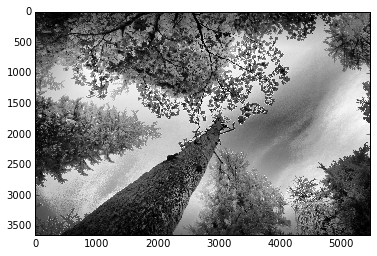

In [52]:
gshow(img)

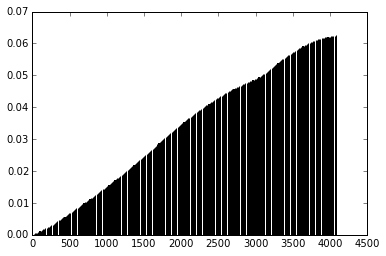

In [53]:
cumhist_np(img)

In [ ]:
img

In [54]:
hist2

array([[  1.25880078e-02,   1.06114381e-01,   2.37599550e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.38054017e-04,   4.73943906e-03,   3.13942752e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.16412742e-05,   1.87557710e-04,   3.29668744e-03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   1.44275162e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   7.21375808e-06,   1.37061404e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [63]:
hist_norm.shape

(12, 12, 256)

In [72]:
segmentationsize=12
hist_norm = (hist.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)

In [73]:
cumsumhist.shape

(12, 12, 256)

In [74]:
cumsumhist

array([[[  3,  30,  91, ..., 255, 255, 255],
        [  1,  11,  39, ..., 255, 255, 255],
        [  0,   1,   7, ..., 255, 255, 255],
        ..., 
        [  0,   0,   0, ..., 256, 256, 256],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255]],

       [[  0,   1,   9, ..., 255, 255, 255],
        [  0,   2,   9, ..., 255, 255, 255],
        [  0,   4,  15, ..., 255, 255, 255],
        ..., 
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 256, 256, 256],
        [  0,   0,   0, ..., 255, 255, 255]],

       [[  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   1, ..., 255, 255, 255],
        [  0,   0,   6, ..., 256, 256, 256],
        ..., 
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255]],

       ..., 
       [[  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 256, 256, 256],
        [  0,   0,   0, ..., 256, 256, 